In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from scipy.stats import pearsonr

import sys
sys.path.append('../')
from utilities import data, roc, threshold

## directory where results are
CHANSEY_ROOT = "W:"
CHANSEY_DIR = f"{CHANSEY_ROOT}/experiments/lung-malignancy-fairness-shaurya"
TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"

## Merge scan sizes and check them

In [3]:
sybil_scan_sizes = pd.read_csv(f"{TEAMS_DIR}/nlst/nlst_demov4_scan_sizes.csv")
sybil_scan_sizes.describe()

,SeriesX,SeriesY,SeriesZ
count,5911.0,5911.0,5911.000000
mean,512.0,512.0,170.376924
std,0.0,0.0,49.720287
min,512.0,512.0,68.000000
25%,512.0,512.0,142.000000
50%,512.0,512.0,160.000000
75%,512.0,512.0,180.000000
max,512.0,512.0,634.000000


In [4]:
exact = sybil_scan_sizes.query('SeriesZ == 200')
padded = sybil_scan_sizes.query('SeriesZ < 200')
truncd = sybil_scan_sizes.query('SeriesZ > 200')
print(f"{len(exact)} exact, {len(padded)} padded, {len(truncd)} truncated")

8 exact, 4964 padded, 939 truncated


<Axes: xlabel='SeriesZ', ylabel='Count'>

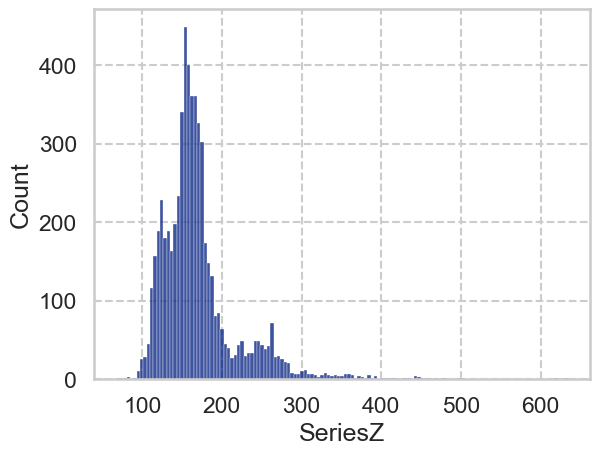

In [5]:
sns.histplot(sybil_scan_sizes, x='SeriesZ')

In [6]:
sybil_scan_sizes['SliceCount'] = sybil_scan_sizes['SeriesZ']

In [7]:
nlst_preds = pd.read_csv(f"{TEAMS_DIR}/nlst/nlst_demov4_allmodels_cal.csv")
if 'SliceCount' not in nlst_preds.columns:
    merged_df = nlst_preds.merge(sybil_scan_sizes[['SeriesInstanceUID', 'SliceCount']], on='SeriesInstanceUID', how='left', validate='m:1', suffixes=('', ''))
else:
    merged_df = nlst_preds

In [8]:
nlst_preds.info(), merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 131 entries, PatientID to SliceCount
dtypes: bool(27), float64(86), int64(12), object(6)
memory usage: 13.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 131 entries, PatientID to SliceCount
dtypes: bool(27), float64(86), int64(12), object(6)
memory usage: 13.2+ MB


(None, None)

In [9]:
merged_df.drop_duplicates(subset='SeriesInstanceUID')['SliceCount'].describe()

count    5911.000000
mean      170.376924
std        49.720287
min        68.000000
25%       142.000000
50%       160.000000
75%       180.000000
max       634.000000
Name: SliceCount, dtype: float64

### Save files

In [10]:
# merged_df.to_csv(f"{TEAMS_DIR}/nlst/nlst_demov4_allmodels_cal.csv", index=False)

In [11]:
# with open(f'{TEAMS_DIR}/nlst/nlst_demo_v4_cols.json') as json_data:
#     nlst_democols_original = json.load(json_data)
#     json_data.close()

# nlst_democols_original['num']['other'].append('SliceCount')
# nlst_democols_original

In [12]:
# with open(f'{TEAMS_DIR}/nlst/nlst_demo_v4_cols.json', 'w') as f:
#     json.dump(nlst_democols_original, f)

## Analyze one characteristic

In [13]:
nlst_preds_nodule = pd.read_csv(f"{TEAMS_DIR}/nlst/nlst_demov4_allmodels_cal.csv")
with open(f'{TEAMS_DIR}/nlst/nlst_demo_v4_cols.json') as json_data:
    nlst_democols_original = json.load(json_data)
    json_data.close()

nlst_democols_original

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'nodule': ['CoordX', 'CoordZ', 'CoordY', 'Mean_Entropy_Kiran'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'ca

In [14]:
df, cols, models = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_original, scanlevel=True, tijmen=False, sybil=True)
print(len(df))
display(models)
display(cols)

5911


{'Venkadesh': 'DL_cal',
 'de Haas Local': 'Thijmen_local_cal',
 'de Haas Global (hidden nodule)': 'Thijmen_global_hidden_cal',
 'de Haas Global (shown nodule)': 'Thijmen_global_show_cal',
 'Sybil year 1': 'sybil_year1',
 'PanCan2b': 'PanCan2b'}

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Age > 61',
   'Gender',
   'HighSchoolPlus',
   'Married',
   'NonHispanicWhite',
   'Overweight',
   'Unfinished_ed',
   'WhiteOrBlack',
   'educat',
   'ethnic',
   'height > 68',
   'marital',
   'race',
   'weight > 180'],
  'smoke': ['cigar',
   'cigsmok',
   'pipe',
   'pkyr > 55',
   'smokeage > 16',
   'smokeday > 25',
   'smokelive',
   'smokework',
   'smokeyr > 40'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'di

In [15]:
category = 'SliceCount > 200'

### ROC results

,num,pct,mal,ben,pct_mal
False,4972,84.114363,462,4510,9.292035
True,939,15.885637,119,820,12.673056


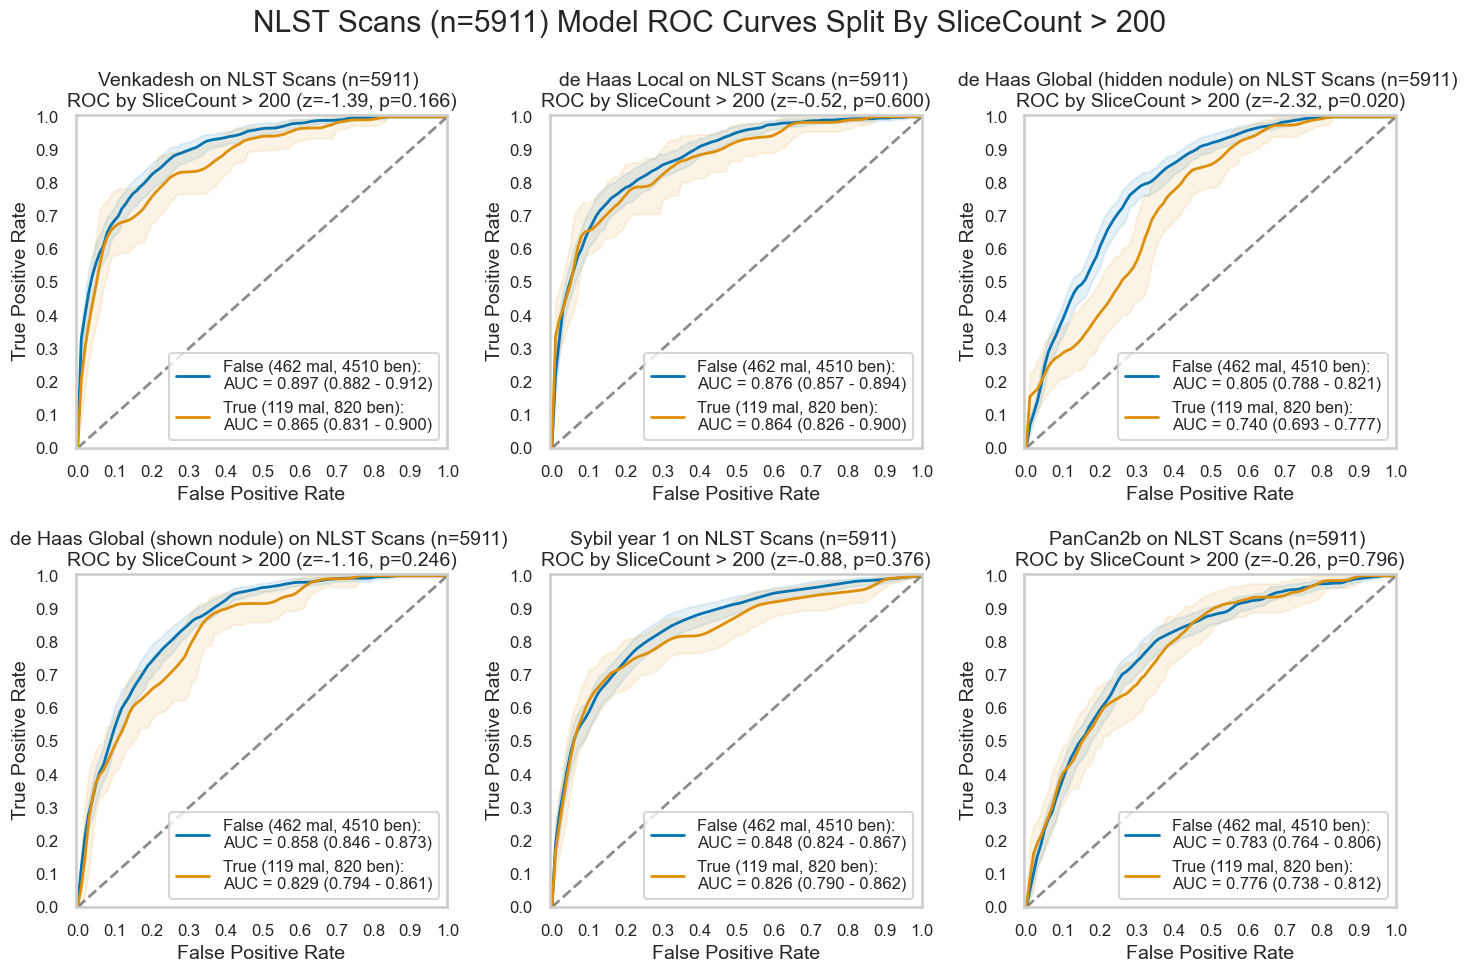

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2
Venkadesh,0.165621,False,0.896973,0.881696,0.911637,True,0.865005,0.831401,0.900224
de Haas Local,0.599959,False,0.875959,0.857456,0.894152,True,0.863667,0.826395,0.900163
de Haas Global (hidden nodule),0.020358,False,0.805072,0.788192,0.821145,True,0.740013,0.693447,0.776993
de Haas Global (shown nodule),0.245534,False,0.85809,0.846264,0.87323,True,0.828841,0.794437,0.861232
Sybil year 1,0.376287,False,0.848379,0.824288,0.867475,True,0.825898,0.790122,0.861759
PanCan2b,0.795709,False,0.782953,0.763651,0.805767,True,0.775835,0.737695,0.811624


In [16]:
_, auc, z, p = roc.plot_rocs_subgroups(df, category, models=models, dataset_name="NLST Scans")

C:\Users\shaur\AppData\Local\Temp\ipykernel_2316\1142346531.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby(f'bin_SliceCount')[['label', f'SliceCount']].describe())


label                                               \
                 count      mean       std  min  25%  50%  75%  max   
bin_SliceCount                                                        
(50, 100]         38.0  0.026316  0.162221  0.0  0.0  0.0  0.0  1.0   
(100, 150]      1227.0  0.106764  0.308939  0.0  0.0  0.0  0.0  1.0   
(150, 200]      2941.0  0.094186  0.292136  0.0  0.0  0.0  0.0  1.0   
(200, 250]      1443.0  0.108801  0.311497  0.0  0.0  0.0  0.0  1.0   
(250, 300]       218.0  0.064220  0.245709  0.0  0.0  0.0  0.0  1.0   
(300, 700]        23.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   

               SliceCount                                                     \
                    count        mean        std    min    25%    50%    75%   
bin_SliceCount                                                                 
(50, 100]            38.0  172.736842  45.185315  110.0  145.0  163.5  195.0   
(100, 150]         1227.0  172.698452  50.320526   99.0  143.0  162.0  185.5   
(150, 200]         2941.0  170.012241  48.767872   68.0  142.0  161.0  179.0   
(200, 250]         1443.0  170.600139  53.192219   84.0  141.0  159.0  180.0   
(250, 300]          218.0  161.798165  32.462749   79.0  145.0  160.0  173.0   
(300, 700]           23.0  167.130435  22.101634  126.0  153.0  167.0  181.0   

                       
                  max  
bin_SliceCount         
(50, 100]       279.0  
(100, 150]      477.0  
(150, 200]      620.0  
(200, 250]      634.0  
(250, 300]      361.0  
(300, 700]      207.0

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(cat)


,num,pct,mal,ben,pct_mal
"(50, 100]",38,0.642869,1,37,2.631579
"(100, 150]",1227,20.757909,131,1096,10.676447
"(150, 200]",2941,49.754695,277,2664,9.418565
"(200, 250]",1443,24.412113,157,1286,10.880111
"(250, 300]",218,3.688039,14,204,6.422018
"(300, 700]",23,0.389105,0,23,0.000000


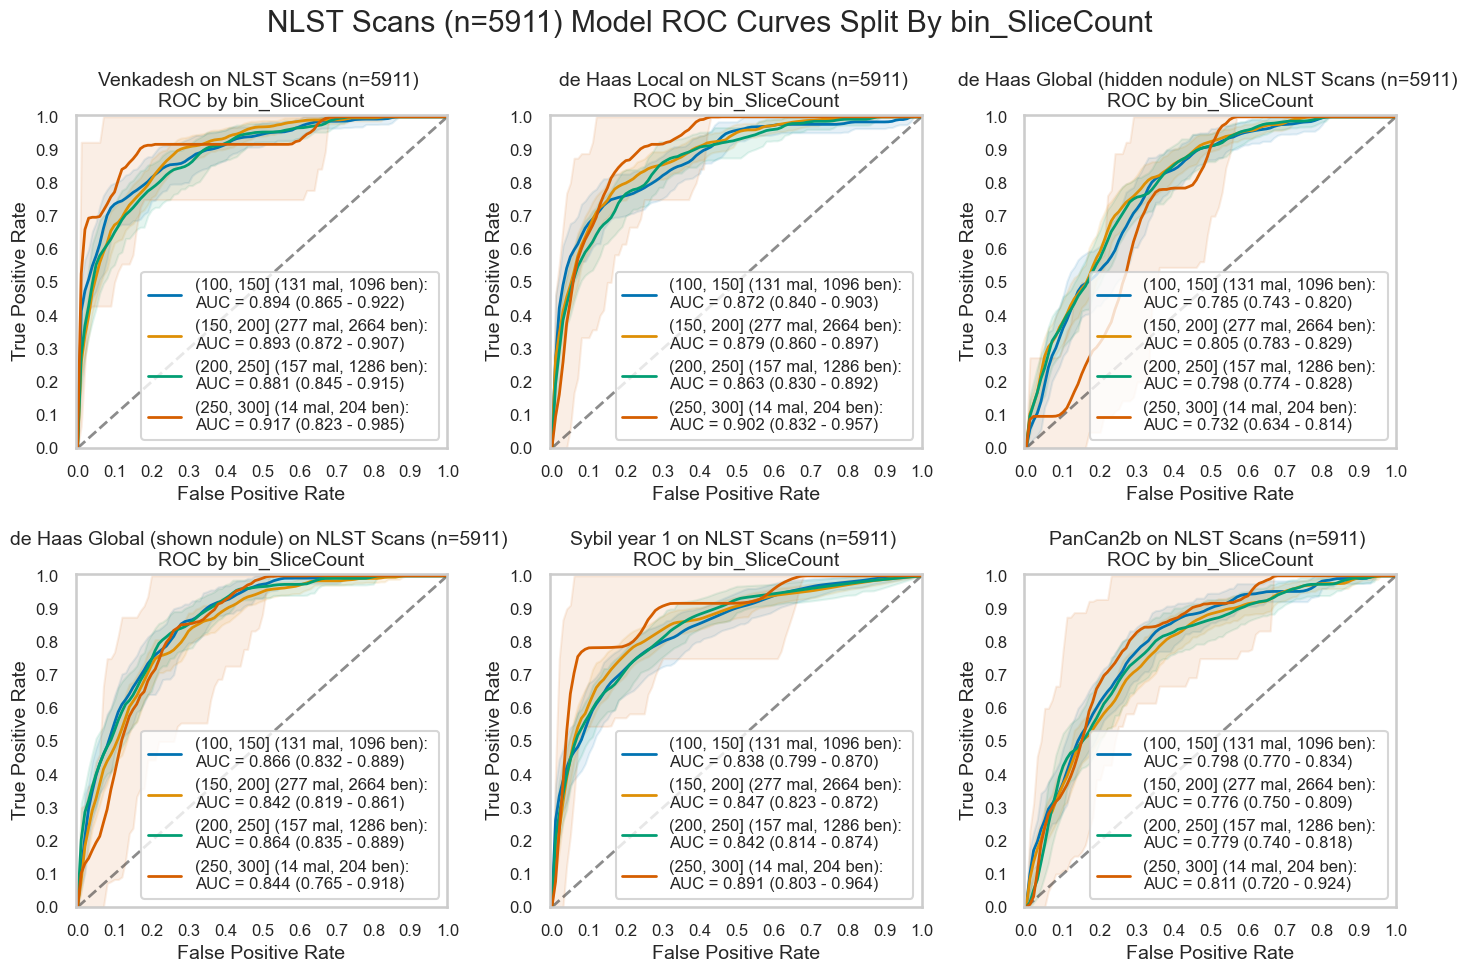

In [17]:
df['bin_SliceCount'] = pd.cut(nlst_preds['weight'], bins=[50, 100, 150, 200, 250, 300, 700], right=True)
display(df.groupby(f'bin_SliceCount')[['label', f'SliceCount']].describe())
_, auc, z, p = roc.plot_rocs_subgroups(df, 'bin_SliceCount', models=models, dataset_name="NLST Scans")

### Threshold results

In [18]:
policies = (
    ("Sensitivity", 0.9),
    # ("Sensitivity", 1.0),
    ("Specificity", 0.9),
    # ("Specificity", 1.0),
    # ("Youden J", 1.0),  ## Max J statistic
)

policy_threshold_df, _ = threshold.get_threshold_policies(df, models=models, policies=policies, brock=True)

,num,pct,mal,ben,pct_mal
False,4972,84.114363,462,4510,9.292035
True,939,15.885637,119,820,12.673056


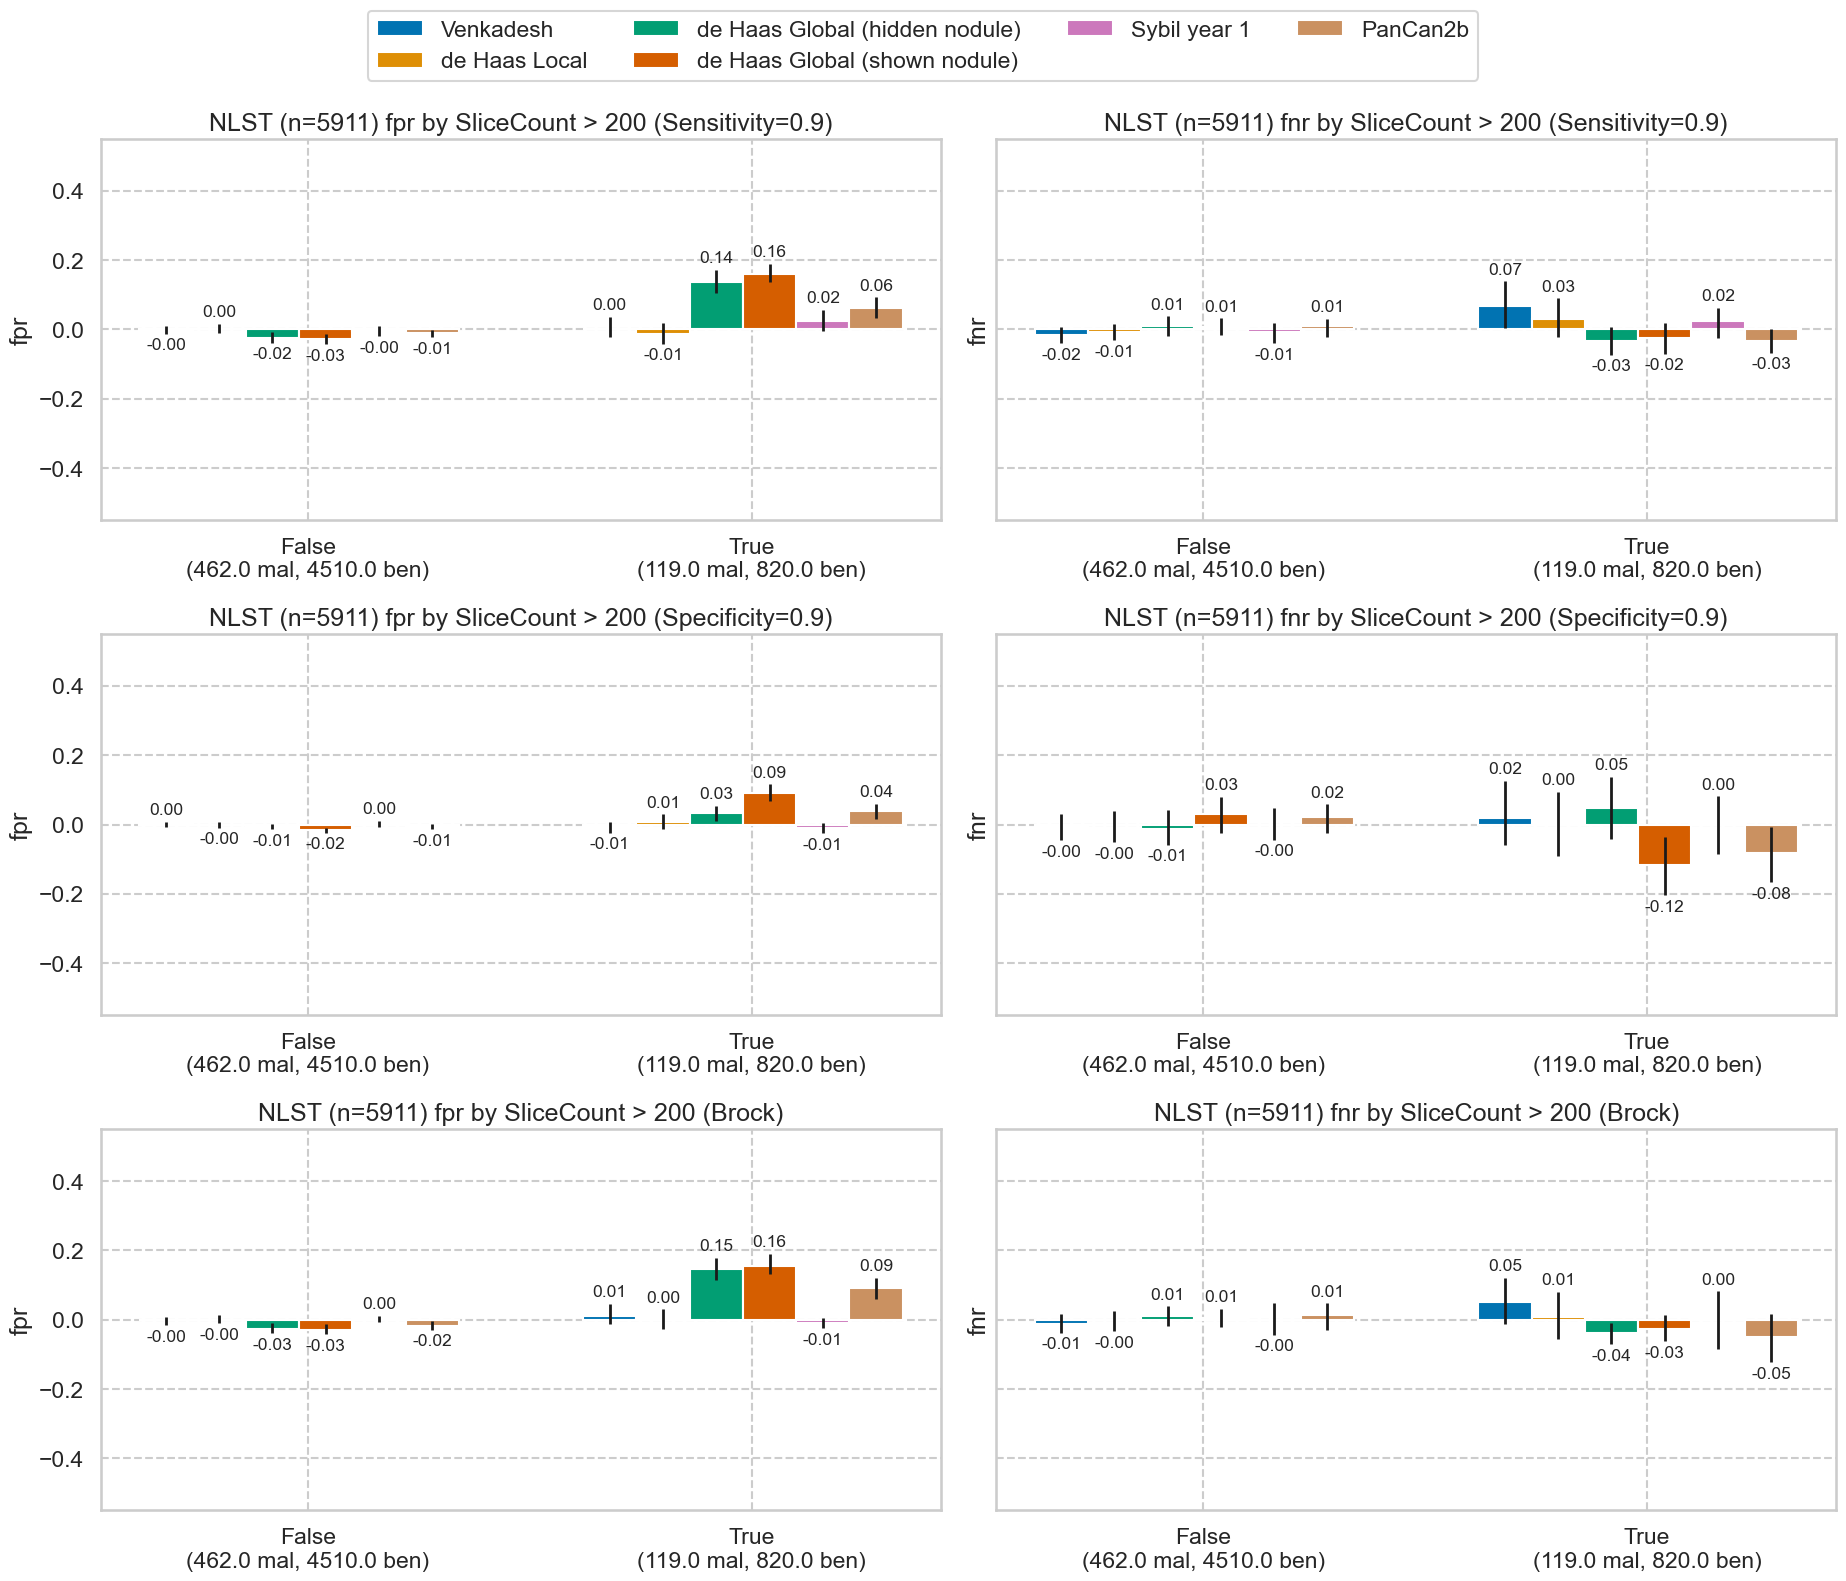

In [19]:
stats = threshold.plot_threshold_stats_subgroups(
    df, category, policy_threshold_df,
    models=models,
    plot_metrics=['fpr', 'fnr'],
    diff=True, show_all=False,
    min_mal=10,
)

### Dataset correlations

In [20]:
dfsets = {k: table for k, table in df.groupby(category)}
values = [k for k, _ in df.groupby(category)]

In [21]:
catdf = data.combine_diff_dfs(
    cols=cols['cat'],
    df_func=data.diffs_category_prevalence,
    dfsets=dfsets,
    dispdf=False,
    include_stat=True,  ## Not applicable for comparing datasets since they have overlap.
)
display(catdf.sort_values(by=f'diff_{values[0]}_{values[1]}', ascending=True).head(40))
display(catdf.sort_values(by=f'diff_{values[0]}_{values[1]}', ascending=False).head(40))

C:\Users\shaur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\proportion.py:1769: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratio = p1 / (1 - p1) / p2 * (1 - p2)


,category,attribute,value,False_freq,False_norm,True_freq,True_norm,diff_False_True,stat_False_True,p_False_True
271,scanner,ManufacturersModelName,LightSpeed Ultra,86.0,1.7297,197.0,20.9798,-19.2501,-14.349319,1.075882e-46
257,scanner,Manufacturer,GE MEDICAL SYSTEMS,2065.0,41.5326,565.0,60.1704,-18.6378,-10.688383,1.153653e-26
269,scanner,ManufacturersModelName,LightSpeed Pro 16,118.0,2.3733,131.0,13.9510,-11.5777,-10.057867,8.481610e-24
46,smoke,cigar,1.0,878.0,17.6589,270.0,28.7540,-11.0951,-7.053739,1.741734e-12
277,scanner,ManufacturersModelName,Sensation 16,598.0,12.0274,217.0,23.1097,-11.0823,-7.638177,2.203194e-14
51,smoke,pipe,1.0,1017.0,20.4545,284.0,30.2449,-9.7904,-6.102289,1.045598e-09
220,other,Diameter_mm > 7,True,2438.0,49.0346,549.0,58.4665,-9.4319,-5.366729,8.017752e-08
116,disease,diagpneu,1.0,1092.0,21.9630,290.0,30.8839,-8.9209,-5.513515,3.517377e-08
224,other,FamilyHistoryLungCa,True,1214.0,24.4167,313.0,33.3333,-8.9166,-5.388916,7.088379e-08
49,smoke,cigsmok,1,2440.0,49.0748,541.0,57.6145,-8.5397,-4.847621,1.249506e-06


,category,attribute,value,False_freq,False_norm,True_freq,True_norm,diff_False_True,stat_False_True,p_False_True
280,scanner,ManufacturersModelName,Volume Zoom,1264.0,25.4224,44.0,4.6858,20.7366,22.400349,3.905101e-111
45,smoke,cigar,0.0,4069.0,81.8383,669.0,71.2460,10.5923,6.725257,1.752830e-11
115,disease,diagpneu,0.0,3876.0,77.9566,638.0,67.9446,10.0120,6.132834,8.632711e-10
219,other,Diameter_mm > 7,False,2534.0,50.9654,390.0,41.5335,9.4319,5.366729,8.017752e-08
259,scanner,Manufacturer,SIEMENS,2063.0,41.4924,304.0,32.3749,9.1175,5.429541,5.649914e-08
50,smoke,pipe,0.0,3920.0,78.8415,655.0,69.7551,9.0864,5.654455,1.563419e-08
223,other,FamilyHistoryLungCa,False,3758.0,75.5833,626.0,66.6667,8.9166,5.388916,7.088379e-08
48,smoke,cigsmok,0,2532.0,50.9252,398.0,42.3855,8.5397,4.847621,1.249506e-06
202,nodule,GroundGlassOpacity,True,1437.0,28.9019,199.0,21.1928,7.7091,5.207030,1.918868e-07
226,other,NoduleCounts > 1,True,2459.0,49.4570,398.0,42.3855,7.0715,4.014098,5.967351e-05


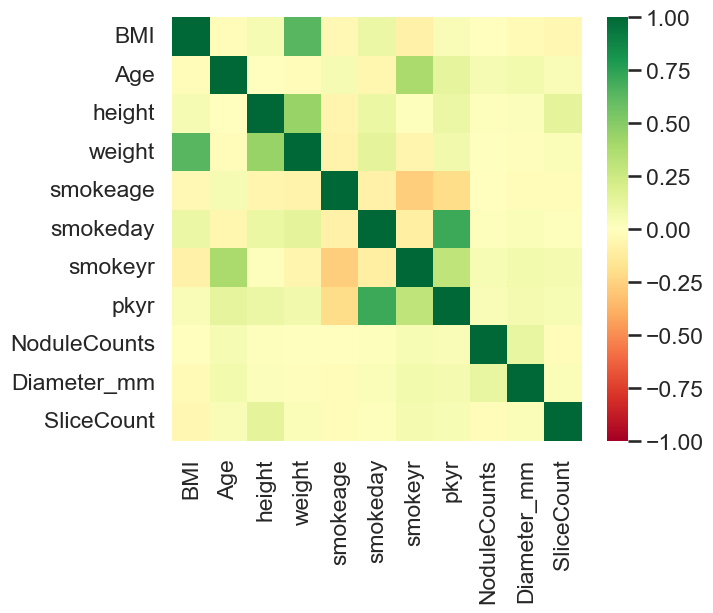

PearsonRResult(statistic=np.float64(0.13105176144288466), pvalue=np.float64(5.059187527013309e-24))

In [24]:
cols_num = sum(cols['num'].values(), start=[])
data.corrmat(df, rows=cols_num, cols=cols_num)

df2 = df.dropna(subset=['SliceCount', 'height'], axis=0)
pearsonr(df2['SliceCount'], df2['height'])

In [ ]:
numdf = data.combine_diff_dfs(
    cols=cols['num'],
    df_func=data.diffs_numerical_means,
    dfsets=dfsets,
    dispdf=False,
    include_stat=True,  ## Not applicable for comparing datasets since they have overlap.
)
display(numdf.sort_values(by='diff_False_True', ascending=True).head(40))
display(numdf.sort_values(by='diff_False_True', ascending=False).head(40))

,category,attribute,value,False,True,diff_False_True,stat_False_True,p_False_True
20,other,SliceCount,mean,153.1380,261.6571,-108.5191,-101.750079,0.000000e+00
19,other,SliceCount,50%,156.0000,250.0000,-94.0000,-101.750079,0.000000e+00
14,smoke,pkyr,50%,50.0000,52.5000,-2.5000,-1.576607,1.149395e-01
15,smoke,pkyr,mean,58.0912,59.5019,-1.4107,-1.576607,1.149395e-01
18,other,Diameter_mm,mean,8.8628,10.0288,-1.1660,-5.483757,4.336561e-08
13,smoke,smokeyr,mean,40.9837,42.1470,-1.1633,-4.428471,9.661402e-06
12,smoke,smokeyr,50%,41.0000,42.0000,-1.0000,-4.428471,9.661402e-06
2,demo,Age,50%,62.0000,63.0000,-1.0000,-2.368357,1.789927e-02
17,other,Diameter_mm,50%,7.0000,8.0000,-1.0000,-5.483757,4.336561e-08
3,demo,Age,mean,63.1134,63.5570,-0.4436,-2.368357,1.789927e-02


,category,attribute,value,False,True,diff_False_True,stat_False_True,p_False_True
6,demo,weight,50%,180.0000,176.0000,4.0000,1.625437,1.041230e-01
7,demo,weight,mean,182.2835,180.0096,2.2739,1.625437,1.041230e-01
1,demo,BMI,mean,27.6434,27.0876,0.5558,3.158268,1.595120e-03
0,demo,BMI,50%,26.9411,26.4439,0.4972,3.158268,1.595120e-03
11,smoke,smokeday,mean,28.6714,28.4633,0.2081,0.499375,6.175338e-01
16,other,NoduleCounts,mean,1.9278,1.7529,0.1749,3.927965,8.664399e-05
10,smoke,smokeday,50%,25.0000,25.0000,0.0000,0.499375,6.175338e-01
4,demo,height,50%,68.0000,68.0000,0.0000,-1.693901,9.033689e-02
8,smoke,smokeage,50%,16.0000,16.0000,0.0000,-0.054834,9.562728e-01
9,smoke,smokeage,mean,16.4916,16.4984,-0.0068,-0.054834,9.562728e-01


<Axes: xlabel='SliceCount', ylabel='Count'>

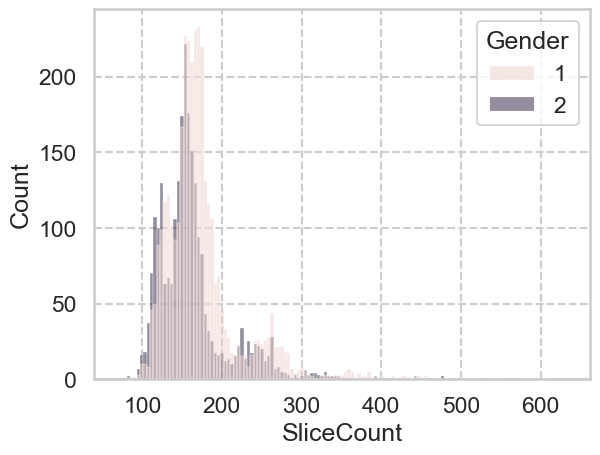

In [ ]:
sns.histplot(df, x='SliceCount', hue='Gender')